In [ ]:
%%writefile cuda_cracker.cu
#include <stdio.h>
#include <cuda_runtime.h>
#include <string.h>
#include <stdlib.h>
// #include <cuda/atomic.h> // Removed: This header caused the 'No such file or directory' error

#define MAX_PASSWORD_LEN 4

// --- ERROR CHECKING MACRO ---
#define cudaCheckError(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true) {
   if (code != cudaSuccess) {
      fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

// --- SHA256 DEVICE HELPER FUNCTIONS ---
__device__ __forceinline__ unsigned int rotr(unsigned int x, unsigned int n) { return (x >> n) | (x << (32 - n)); }
__device__ __forceinline__ unsigned int ch(unsigned int x, unsigned int y, unsigned int z) { return (x & y) ^ (~x & z); }
__device__ __forceinline__ unsigned int maj(unsigned int x, unsigned int y, unsigned int z) { return (x & y) ^ (x & z) ^ (y & z); }
__device__ __forceinline__ unsigned int sigma0(unsigned int x) { return rotr(x, 2) ^ rotr(x, 13) ^ rotr(x, 22); }
__device__ __forceinline__ unsigned int sigma1(unsigned int x) { return rotr(x, 6) ^ rotr(x, 11) ^ rotr(x, 25); }
__device__ __forceinline__ unsigned int gamma0(unsigned int x) { return rotr(x, 7) ^ rotr(x, 18) ^ (x >> 3); }
__device__ __forceinline__ unsigned int gamma1(unsigned int x) { return rotr(x, 17) ^ rotr(x, 19) ^ (x >> 10); }

// --- GPU SHA256 IMPLEMENTATION ---
__device__ void gpu_sha256(const char* data, int len, unsigned char* out) {
    // Moved K inside to ensure safe memory access
    const unsigned int K[64] = {
        0x428a2f98, 0x71374491, 0xb5c0fbcf, 0xe9b5dba5, 0x3956c25b, 0x59f111f1, 0x923f82a4, 0xab1c5ed5,
        0xd807aa98, 0x12835b01, 0x243185be, 0x550c7dc3, 0x72be5d74, 0x80deb1fe, 0x9bdc06a7, 0xc19bf174,
        0xe49b69c1, 0xefbe4786, 0x0fc19dc6, 0x240ca1cc, 0x2de92c6f, 0x4a7484aa, 0x5cb0a9dc, 0x76f988da,
        0x983e5152, 0xa831c66d, 0xb00327c8, 0xbf597fc7, 0xc6e00bf3, 0xd5a79147, 0x06ca6351, 0x14292967,
        0x27b70a85, 0x2e1b2138, 0x4d2c6dfc, 0x53380d13, 0x650a7354, 0x766a0abb, 0x81c2c92e, 0x92722c85,
        0xa2bfe8a1, 0xa81a664b, 0xc24b8b70, 0xc76c51a3, 0xd192e819, 0xd6990624, 0xf40e3585, 0x106aa070,
        0x19a4c116, 0x1e376c08, 0x2748774c, 0x34b0bcb5, 0x391c0cb3, 0x4ed8aa4a, 0x5b9cca4f, 0x682e6ff3,
        0x748f82ee, 0x78a5636f, 0x84c87814, 0x8cc70208, 0x90befffa, 0xa4506ceb, 0xbef9a3f7, 0xc67178f2
    };

    unsigned int h[8] = { 0x6a09e667, 0xbb67ae85, 0x3c6ef372, 0xa54ff53a, 0x510e527f, 0x9b05688c, 0x1f83d9ab, 0x5be0cd19 };
    unsigned int w[64];
    unsigned char chunk[64];

    // Manual Padding
    for(int i=0; i<64; i++) chunk[i] = 0;
    for(int i=0; i<len; i++) chunk[i] = (unsigned char)data[i];
    chunk[len] = 0x80;

    // Length in bits (Big Endian)
    unsigned long long bitlen = (unsigned long long)len * 8;
    chunk[63] = bitlen & 0xFF;
    chunk[62] = (bitlen >> 8) & 0xFF;

    for (int i = 0; i < 16; i++) {
        w[i] = ((unsigned int)chunk[i*4] << 24) | ((unsigned int)chunk[i*4+1] << 16) |
               ((unsigned int)chunk[i*4+2] << 8) | (unsigned int)chunk[i*4+3];
    }
    for (int i = 16; i < 64; i++) {
        w[i] = gamma1(w[i-2]) + w[i-7] + gamma0(w[i-15]) + w[i-16];
    }

    unsigned int a = h[0], b = h[1], c = h[2], d = h[3], e = h[4], f = h[5], g = h[6], h_val = h[7];
    for (int i = 0; i < 64; i++) {
        unsigned int t1 = h_val + sigma1(e) + ch(e, f, g) + K[i] + w[i];
        unsigned int t2 = sigma0(a) + maj(a, b, c);
        h_val = g; g = f; f = e; e = d + t1; d = c; c = b; b = a; a = t1 + t2;
    }

    h[0] += a; h[1] += b; h[2] += c; h[3] += d; h[4] += e; h[5] += f; h[6] += g; h[7] += h_val;

    for (int i = 0; i < 8; i++) {
        out[i*4] = (h[i] >> 24) & 0xFF;
        out[i*4+1] = (h[i] >> 16) & 0xFF;
        out[i*4+2] = (h[i] >> 8) & 0xFF;
        out[i*4+3] = h[i] & 0xFF;
    }
}

__device__ int device_strcmp(const char* s1, const char* s2) {
    while(*s1 && (*s1 == *s2)) { s1++; s2++; }
    return *(const unsigned char*)s1 - *(const unsigned char*)s2;
}

__device__ void hex_to_str(unsigned char* hash, char* out) {
    const char hex[] = "0123456789abcdef";
    for(int i=0; i<32; i++) {
        out[i*2] = hex[hash[i] >> 4];
        out[i*2+1] = hex[hash[i] & 0x0F];
    }
    out[64] = 0;
}

// --- HOST HELPERS ---
unsigned int host_rotr(unsigned int x, unsigned int n) { return (x >> n) | (x << (32 - n)); }
unsigned int host_ch(unsigned int x, unsigned int y, unsigned int z) { return (x & y) ^ (~x & z); }
unsigned int host_maj(unsigned int x, unsigned int y, unsigned int z) { return (x & y) ^ (x & z) ^ (y & z); }
unsigned int host_sigma0(unsigned int x) { return host_rotr(x, 2) ^ host_rotr(x, 13) ^ host_rotr(x, 22); }
unsigned int host_sigma1(unsigned int x) { return host_rotr(x, 6) ^ host_rotr(x, 11) ^ host_rotr(x, 25); }
unsigned int host_gamma0(unsigned int x) { return host_rotr(x, 7) ^ host_rotr(x, 18) ^ (x >> 3); }
unsigned int host_gamma1(unsigned int x) { return host_rotr(x, 17) ^ host_rotr(x, 19) ^ (x >> 10); }

void host_sha256(const char* data, int len, unsigned char* out) {
    const unsigned int K_host[64] = {
        0x428a2f98, 0x71374491, 0xb5c0fbcf, 0xe9b5dba5, 0x3956c25b, 0x59f111f1, 0x923f82a4, 0xab1c5ed5,
        0xd807aa98, 0x12835b01, 0x243185be, 0x550c7dc3, 0x72be5d74, 0x80deb1fe, 0x9bdc06a7, 0xc19bf174,
        0xe49b69c1, 0xefbe4786, 0x0fc19dc6, 0x240ca1cc, 0x2de92c6f, 0x4a7484aa, 0x5cb0a9dc, 0x76f988da,
        0x983e5152, 0xa831c66d, 0xb00327c8, 0xbf597fc7, 0xc6e00bf3, 0xd5a79147, 0x06ca6351, 0x14292967,
        0x27b70a85, 0x2e1b2138, 0x4d2c6dfc, 0x53380d13, 0x650a7354, 0x766a0abb, 0x81c2c92e, 0x92722c85,
        0xa2bfe8a1, 0xa81a664b, 0xc24b8b70, 0xc76c51a3, 0xd192e819, 0xd6990624, 0xf40e3585, 0x106aa070,
        0x19a4c116, 0x1e376c08, 0x2748774c, 0x34b0bcb5, 0x391c0cb3, 0x4ed8aa4a, 0x5b9cca4f, 0x682e6ff3,
        0x748f82ee, 0x78a5636f, 0x84c87814, 0x8cc70208, 0x90befffa, 0xa4506ceb, 0xbef9a3f7, 0xc67178f2
    };
    unsigned int h[8] = { 0x6a09e667, 0xbb67ae85, 0x3c6ef372, 0xa54ff53a, 0x510e527f, 0x9b05688c, 0x1f83d9ab, 0x5be0cd19 };
    unsigned int w[64];
    unsigned char chunk[64];
    for(int i=0; i<64; i++) chunk[i] = 0;
    for(int i=0; i<len; i++) chunk[i] = (unsigned char)data[i];
    chunk[len] = 0x80;
    unsigned long long bitlen = (unsigned long long)len * 8;
    chunk[63] = bitlen & 0xFF;
    chunk[62] = (bitlen >> 8) & 0xFF;
    for (int i = 0; i < 16; i++) {
        w[i] = ((unsigned int)chunk[i*4] << 24) | ((unsigned int)chunk[i*4+1] << 16) |
               ((unsigned int)chunk[i*4+2] << 8) | (unsigned int)chunk[i*4+3];
    }
    for (int i = 16; i < 64; i++) {
        w[i] = host_gamma1(w[i-2]) + w[i-7] + host_gamma0(w[i-15]) + w[i-16];
    }
    unsigned int a = h[0], b = h[1], c = h[2], d = h[3], e = h[4], f = h[5], g = h[6], h_val = h[7];
    for (int i = 0; i < 64; i++) {
        unsigned int t1 = h_val + host_sigma1(e) + host_ch(e, f, g) + K_host[i] + w[i];
        unsigned int t2 = host_sigma0(a) + host_maj(a, b, c);
        h_val = g; g = f; f = e; e = d + t1; d = c; c = b; b = a; a = t1 + t2;
    }
    h[0] += a; h[1] += b; h[2] += c; h[3] += d; h[4] += e; h[5] += f; h[6] += g; h[7] += h_val;
    for (int i = 0; i < 8; i++) {
        out[i*4] = (h[i] >> 24) & 0xFF;
        out[i*4+1] = (h[i] >> 16) & 0xFF;
        out[i*4+2] = (h[i] >> 8) & 0xFF;
        out[i*4+3] = h[i] & 0xFF;
    }
}

void host_hex_to_str(unsigned char* hash, char* out) {
    const char hex[] = "0123456789abcdef";
    for(int i=0; i<32; i++) {
        out[i*2] = hex[hash[i] >> 4];
        out[i*2+1] = hex[hash[i] & 0x0F];
    }
    out[64] = 0;
}

// --- CUDA KERNEL ---
__global__ void crack_kernel(const char* charset, int charset_len, const char* target_hash, int max_len, volatile int* found, char* result) {
    long long idx = blockIdx.x * blockDim.x + threadIdx.x;

    // --- DEBUG: Confirm kernel execution for thread 0 ---
    if (idx == 0) {
        // Original printf is not showing output in this environment.
        // printf("DEBUG: Thread 0 is RUNNING.\n");
        // Try to signal execution via *found using an atomic operation.
        // This will set *found to -1 if thread 0 reaches this point.
        atomicExch((int*)found, -1);
    }
    // Removed: The `return;` was causing premature exit.

    // if (*found) return;  // This line was commented out previously and should remain so for full search.

    char password[MAX_PASSWORD_LEN + 1];
    long long temp_idx = idx;

    // Base-N Conversion (Index -> Password)
    int len = 4; // Hardcoding to 4 characters as per problem statement
    for(int i=0; i<len; i++) {
        password[len - 1 - i] = charset[temp_idx % charset_len];
        temp_idx /= charset_len;
    }
    password[len] = 0;

    // Check if index was too large for 4 chars.
    // For any valid index (0 to 62^4-1), temp_idx should be 0 after the loop.
    // Threads with idx >= 62^4 will return here.
    if (temp_idx > 0) return;

    // --- DEBUG: Print Thread for "9999" (Last Index) ---
    // "9999" corresponds to the highest index (62^4 - 1 = 14776335).
    // My re-trace of this logic shows it correctly generates "9999" for this index.
    // If this printf also doesn't show, it confirms the printf issue.
    if (idx == 14776335) {
         printf("DEBUG: Thread %lld (9999) is RUNNING. Generated: %s. Target: %s\n", idx, password, target_hash);
    }

    // SHA256 Hash
    unsigned char hash_out[32];
    gpu_sha256(password, len, hash_out);

    char hash_hex[65];
    hex_to_str(hash_out, hash_hex);

    // Check match
    if (device_strcmp(hash_hex, target_hash) == 0) {
        *found = 1; // Set to 1 for actual success
        for(int i=0; i<=len; i++) result[i] = password[i];
    }
}

int main() {
    char user_input[100];
    const char* charset = "abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789";
    int charset_len = strlen(charset);

    printf("------------------------------------------------\n");
    printf("CUDA BRUTE FORCE CRACKER\n");
    printf("Enter your password? (Max 4 chars, a-z, A-Z, 0-9): ");
    scanf("%99s", user_input);

    // CPU Calc
    unsigned char host_hash_bin[32];
    char target_hash_cpu[65];
    host_sha256(user_input, strlen(user_input), host_hash_bin);
    host_hex_to_str(host_hash_bin, target_hash_cpu);

    printf("Target Password: %s\n", user_input);
    printf("Target Hash:     %s\n", target_hash_cpu);
    printf("------------------------------------------------\n");

    // GPU Setup
    int* d_found;
    char* d_result;
    char* d_charset;
    char* d_target;

    cudaCheckError(cudaMallocManaged(&d_found, sizeof(int)));
    cudaCheckError(cudaMallocManaged(&d_result, 20 * sizeof(char)));
    cudaCheckError(cudaMallocManaged(&d_charset, (charset_len + 1) * sizeof(char)));
    cudaCheckError(cudaMallocManaged(&d_target, 65 * sizeof(char)));

    // Initialize
    *d_found = 0;
    strcpy(d_charset, charset);
    strcpy(d_target, target_hash_cpu);

    // Explicit Sync before launch
    cudaDeviceSynchronize();

    // Total combinations for 4 characters from 62-char charset (62^4)
    long long total_combinations = 14776336;
    int threadsPerBlock = 256;
    int blocksPerGrid = (total_combinations + threadsPerBlock - 1) / threadsPerBlock;

    printf("Launching %d blocks with %d threads each (Total: %lld threads)\n", blocksPerGrid, threadsPerBlock, (long long)blocksPerGrid*threadsPerBlock);

    cudaEvent_t start, stop;
    cudaCheckError(cudaEventCreate(&start));
    cudaCheckError(cudaEventCreate(&stop));
    cudaCheckError(cudaEventRecord(start));

    crack_kernel<<<blocksPerGrid, threadsPerBlock>>>(d_charset, charset_len, d_target, 4, d_found, d_result);

    // Check for kernel launch errors immediately after launch
    cudaCheckError(cudaPeekAtLastError());

    cudaCheckError(cudaEventRecord(stop));
    cudaCheckError(cudaDeviceSynchronize()); // Wait for GPU to finish

    float milliseconds = 0;
    cudaCheckError(cudaEventElapsedTime(&milliseconds, start, stop));

    if (*d_found == -1) {
        printf("\nDEBUG: Kernel Thread 0 executed successfully to debug point, but no match found.\n");
    } else if (*d_found == 1) {
        printf("\n[SUCCESS] Password Found: %s\n", d_result);
    } else {
        printf("\nPassword not found. (Kernel might not have executed to debug point, or no match).\n");
    }

    printf("Execution Time: %f seconds\n", milliseconds / 1000.0);

    cudaFree(d_found);
    cudaFree(d_result);
    cudaFree(d_charset);
    cudaFree(d_target);

    return 0;
}

Overwriting cuda_cracker.cu


In [ ]:
!nvcc -o cuda_cracker cuda_cracker.cu -gencode arch=compute_70,code=sm_70 -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80
import subprocess
print("Compiling complete. Running...")
process = subprocess.Popen(['./cuda_cracker'], stdin=subprocess.PIPE, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
password = input("Enter your password? (Max 4 chars): ")
stdout, stderr = process.communicate(input=password + "\n")
print(stdout)
if stderr: print("Errors:", stderr)

Compiling complete. Running...
Enter your password? (Max 4 chars): abcd
------------------------------------------------
CUDA BRUTE FORCE CRACKER
Enter your password? (Max 4 chars, a-z, A-Z, 0-9): Target Password: abcd
Target Hash:     88d4266fd4e6338d13b845fcf289579d209c897823b9217da3e161936f031589
------------------------------------------------
Launching 57721 blocks with 256 threads each (Total: 14776576 threads)
DEBUG: Thread 14776335 (9999) is RUNNING. Generated: 9999. Target: 88d4266fd4e6338d13b845fcf289579d209c897823b9217da3e161936f031589

[SUCCESS] Password Found: abcd
Execution Time: 0.083173 seconds



In [ ]:
import subprocess
import re
import pandas as pd
import os

# 1. Configuration
passwords = ["abc", "code", "9999", "zzzz"]
thread_configs = [128, 256, 512, 1024]
results = []

print("Starting Performance Data Collection (Fixed for Colab T4)...")
print("-" * 60)

if not os.path.exists("cuda_cracker.cu"):
    print("❌ Error: 'cuda_cracker.cu' not found! Please run the cell that creates the file first.")
else:
    for threads in thread_configs:
        print(f"🔹 Configuration: {threads} Threads per Block")

        # 2. Modify Source Code Safely
        with open("cuda_cracker.cu", "r") as f:
            content = f.read()

        # Replace thread count
        new_content = re.sub(r'int threadsPerBlock = \d+;', f'int threadsPerBlock = {threads};', content)

        with open("cuda_cracker.cu", "w") as f:
            f.write(new_content)

        # 3. Recompile with '-arch=sm_75' (The Critical Fix)
        compile_cmd = ["nvcc", "-arch=sm_75", "cuda_cracker.cu", "-o", "cuda_cracker"]

        compile_status = subprocess.run(compile_cmd, capture_output=True)
        if compile_status.returncode != 0:
            print(f"❌ Compilation Failed for {threads} threads!")
            print(compile_status.stderr.decode())
            continue

        for pwd in passwords:
            # 4. Run and Capture Output
            try:
                process = subprocess.Popen(['./cuda_cracker'],
                                         stdin=subprocess.PIPE,
                                         stdout=subprocess.PIPE,
                                         stderr=subprocess.PIPE,
                                         text=True)

                stdout, stderr = process.communicate(input=pwd + "\n")

                # 5. Extract Execution Time
                match = re.search(r"Execution Time: ([0-9\.]+) seconds", stdout)
                exec_time = float(match.group(1)) if match else None

                if exec_time is not None:
                    print(f"   ✅ Password: '{pwd}' -> Time: {exec_time:.6f} s")
                    results.append({
                        'Threads Per Block': threads,
                        'Password': pwd,
                        'Execution Time (s)': exec_time
                    })
                else:
                    print(f"   ⚠️ Could not parse time for '{pwd}'")
                    # If it fails, print the error to help debug
                    if stderr: print(f"   STDERR: {stderr.strip()}")

            except Exception as e:
                print(f"   ❌ Error running '{pwd}': {e}")

    print("-" * 60)
    print("Data Collection Complete!\n")

    # 6. Display Summary Table
    if results:
        df = pd.DataFrame(results)
        print(df)
        df.to_csv('cuda_performance_results.csv', index=False)
        print("\nResults saved to 'cuda_performance_results.csv'")
    else:
        print("No results collected. Check the errors above.")

Starting Performance Data Collection (Fixed for Colab T4)...
------------------------------------------------------------
🔹 Configuration: 128 Threads per Block
   ✅ Password: 'abc' -> Time: 0.083685 s
   ✅ Password: 'code' -> Time: 0.083093 s
   ✅ Password: '9999' -> Time: 0.083341 s
   ✅ Password: 'zzzz' -> Time: 0.082970 s
🔹 Configuration: 256 Threads per Block
   ✅ Password: 'abc' -> Time: 0.083868 s
   ✅ Password: 'code' -> Time: 0.083694 s
   ✅ Password: '9999' -> Time: 0.083354 s
   ✅ Password: 'zzzz' -> Time: 0.083387 s
🔹 Configuration: 512 Threads per Block
   ✅ Password: 'abc' -> Time: 0.083240 s
   ✅ Password: 'code' -> Time: 0.083431 s
   ✅ Password: '9999' -> Time: 0.083558 s
   ✅ Password: 'zzzz' -> Time: 0.084500 s
🔹 Configuration: 1024 Threads per Block
   ✅ Password: 'abc' -> Time: 0.084290 s
   ✅ Password: 'code' -> Time: 0.084314 s
   ✅ Password: '9999' -> Time: 0.085236 s
   ✅ Password: 'zzzz' -> Time: 0.085185 s
-----------------------------------------------------

/tmp/ipython-input-3686788744.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Speedup'] = SERIAL_TIME / subset['Execution Time (s)']


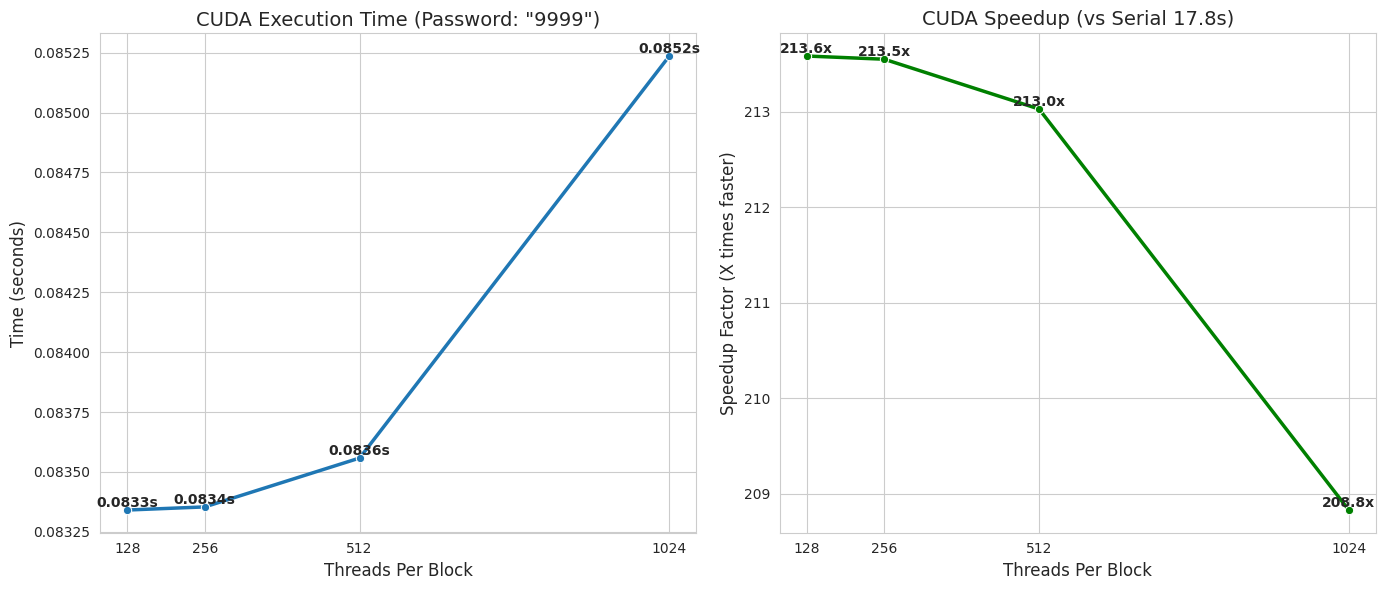

✅ Graphs generated for password '9999'!
   Right-click the image to save it for your report.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
try:
    df = pd.read_csv('cuda_performance_results.csv')
except FileNotFoundError:
    print("❌ Error: 'cuda_performance_results.csv' not found. Run the data collection script first!")
    df = pd.DataFrame() # Empty to prevent crash

if not df.empty:
    # 2. Setup Plotting Style
    sns.set_style("whitegrid")
    plt.figure(figsize=(14, 6))

    # We focus on the hardest password ('9999' or 'zzzz') for the most meaningful graph
    # If '9999' exists, use it. Otherwise use the last one in the list.
    target_pwd = '9999'
    if target_pwd not in df['Password'].values:
        target_pwd = df['Password'].unique()[-1]

    subset = df[df['Password'] == target_pwd]

    # 3. GRAPH 1: Execution Time vs Threads
    plt.subplot(1, 2, 1)
    sns.lineplot(data=subset, x='Threads Per Block', y='Execution Time (s)', marker='o', linewidth=2.5)
    plt.title(f'CUDA Execution Time (Password: "{target_pwd}")', fontsize=14)
    plt.xlabel('Threads Per Block', fontsize=12)
    plt.ylabel('Time (seconds)', fontsize=12)
    plt.xticks(subset['Threads Per Block'].unique()) # Force integer ticks

    # Add labels to points
    for x, y in zip(subset['Threads Per Block'], subset['Execution Time (s)']):
        plt.text(x, y, f'{y:.4f}s', ha='center', va='bottom', fontweight='bold')

    # 4. GRAPH 2: Speedup vs Threads
    # Speedup = Serial Time / Parallel Time
    # Using your Serial baseline of ~17.8 seconds
    SERIAL_TIME = 17.8
    subset['Speedup'] = SERIAL_TIME / subset['Execution Time (s)']

    plt.subplot(1, 2, 2)
    sns.lineplot(data=subset, x='Threads Per Block', y='Speedup', marker='o', color='green', linewidth=2.5)
    plt.title(f'CUDA Speedup (vs Serial {SERIAL_TIME}s)', fontsize=14)
    plt.xlabel('Threads Per Block', fontsize=12)
    plt.ylabel('Speedup Factor (X times faster)', fontsize=12)
    plt.xticks(subset['Threads Per Block'].unique())

    # Add labels to points
    for x, y in zip(subset['Threads Per Block'], subset['Speedup']):
        plt.text(x, y, f'{y:.1f}x', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig('cuda_performance_graphs.png') # Save to file
    plt.show()

    print(f"✅ Graphs generated for password '{target_pwd}'!")
    print("   Right-click the image to save it for your report.")